In [1]:
DF_PATH = "../data/processed/1_preprocessed_df.pkl"

NA_STRING = 'Not Specified'
TRANSPARENT_STRING = 'rgba(0, 0, 0, 0)'

ROLE_COLS      = ['DevType']
TECH_COLS      = ['LanguageWorkedWith',    'DatabaseWorkedWith',    'WebframeWorkedWith',    'MiscTechWorkedWith',    ]
TECH_NEXT_COLS = ['LanguageDesireNextYear','DatabaseDesireNextYear','WebframeDesireNextYear','MiscTechDesireNextYear',]

EXPORT_FEATURES_DIR = "../data/processed/"

In [13]:
# Load packages
import pandas as pd 
import numpy as np
import logging
import pickle
import os
import yaml

import plotly 
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE

from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import silhouette_score

pd.options.display.max_rows = 1000

In [3]:
# Read Data 
df = pd.read_pickle(DF_PATH)


In [4]:
# One hot encode 
encoded_dfs = {}
for col in ROLE_COLS + TECH_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(df[col]),
                               columns=binarizer.classes_,
                               index=df[col].index)
    encoded_dfs[col] = encoded_df
    
# Merge 1-hot encoded 
ohe_df = pd.concat(encoded_dfs, axis=1)

In [5]:
# Prepare sub data frames 
skills_ohe = ohe_df.drop('DevType', axis=1).copy()
std_skills = StandardScaler().fit_transform(skills_ohe)

In [93]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=2.2, 
                       learning_rate=1, 
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**4, 
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=skills_ohe.columns)

In [102]:
fig = px.scatter(x=tsne_projection[0], y=tsne_projection[1], text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=450, width=800, title_text='TSNE')
fig.show()

In [95]:
range_n_cluster = list(range(5,25))
silhoutte_score = []
best_cluster_model = None 

for n_clusters in range_n_cluster:
    cluster_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)
    
    silhouette_avg = silhouette_score(tsne_projection, cluster_labels)
    silhoutte_score += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score):
        best_cluster_model = cluster_model

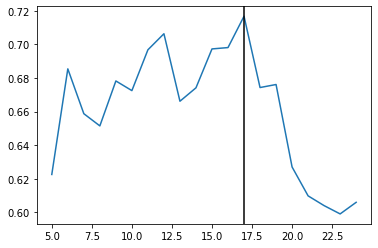

In [96]:
plt.plot(range_n_cluster, silhoutte_score)
plt.axvline(best_cluster_model.n_clusters, color='black')

In [97]:
best_cluster_model.n_clusters

17

In [98]:

cluster_labels = ["skills_group_" + str(label) 
                 for label in best_cluster_model.labels_]

In [99]:
best_cluster_model.labels_.shape

(74,)

In [100]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()


In [25]:
# How to better write this
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)


In [43]:
new_features = []

for cluster, skills in skills_clusters.items():
    cluster_sum = skills_ohe.droplevel(0, axis=1)[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)

In [44]:
fe_clustered_skills

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_2,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,6,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3,2,2,0,0,0,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64457,3,5,3,1,3,0,2,0,2,4,3,1,3,3,1,1,4
64458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64459,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [55]:
class_weights = (1 / ohe_df['DevType'].sum(axis=0))
sample_weight = np.multiply(class_weights.values, 
                            ohe_df['DevType'].values).mean(axis=1)

In [57]:
combined_features_df = pd.concat([fe_clustered_skills, 
                                  skills_ohe.droplevel(0,axis=1)], 
                                 axis=1)
roles_df = ohe_df['DevType'].copy()

In [58]:
combined_features_df

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_2,...,Node.js,Pandas,Puppet,React Native,TensorFlow,Teraform,Torch/PyTorch,Unity 3D,Unreal Engine,Xamarin
0,6,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,2,2,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64457,3,5,3,1,3,0,2,0,2,4,...,0,0,0,0,0,0,0,0,0,0
64458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64459,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(combined_features_df, roles_df, test_size=0.3, random_state=0)


In [61]:
# Assign class weight as an inverse of its frequency 
class_weights = (1 / roles_df.sum(axis=0))

# Multiply class weights with the 1 hot encoded values and get the mean of each sample
sample_weight = np.multiply(class_weights.values, Y_train.values).sum(axis=1)


In [62]:
def f1_from_confusion_matrix(confusion_matrix):
    return (confusion_matrix[1,1] / 
            (confusion_matrix[1,1] + 
             (0.5 * (confusion_matrix[0,1] + confusion_matrix[1,0]))
            ))

In [63]:
feature_sets = {'original': skills_ohe.droplevel(0,axis=1).columns.tolist(), 
                'clusters': fe_clustered_skills.columns.tolist()}


In [64]:
results = {}

for feature_set_name, feature_set in feature_sets.items():
    # Create sub trainings
    sub_train = X_train[feature_set].copy()
    sub_test  = X_test[feature_set].copy()
    
    # Train classifier 
    clf = MultiOutputClassifier(LogisticRegression())
    clf.fit(sub_train, Y_train, sample_weight=sample_weight)

    # Calcaulte F1 for training data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_train, clf.predict(sub_train))
    f1_train_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Calcaulte F1 for testing data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_test, clf.predict(sub_test))
    f1_test_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Add to results
    set_result = pd.DataFrame({"train": f1_train_scores, "test":f1_test_scores}, 
                              index=roles_df.columns.to_list())
    results[feature_set_name] = set_result.sort_values('test')
    
    
    # Print
    print("Feature set: " + feature_set_name)
    print(".. Mean train F1:", np.mean(f1_train_scores))    
    print(".. Mean test F1:", np.mean(f1_test_scores))
    print()

Feature set: original
.. Mean train F1: 0.13532633208643802
.. Mean test F1: 0.13646976895315743

Feature set: clusters
.. Mean train F1: 0.17498249556280707
.. Mean test F1: 0.17841138027655776



In [70]:
multilabel_confusion_matrix(Y_test, clf.predict(sub_test))

array([[[18186,   116],
        [ 1001,    36]],

       [[18094,    59],
        [ 1164,    22]],

       [[17752,   415],
        [  796,   376]],

       [[17270,   334],
        [ 1580,   155]],

       [[17647,    84],
        [ 1577,    31]],

       [[17205,   364],
        [ 1500,   270]],

       [[18138,    25],
        [ 1168,     8]],

       [[ 3906,  7328],
        [  972,  7133]],

       [[14050,  1785],
        [ 2340,  1164]],

       [[17746,   116],
        [ 1418,    59]],

       [[ 9790,  4022],
        [ 1715,  3812]],

       [[ 6714,  4457],
        [ 1480,  6688]],

       [[18484,    32],
        [  793,    30]],

       [[15874,   632],
        [ 2176,   657]],

       [[18455,    11],
        [  867,     6]],

       [[18134,    92],
        [ 1057,    56]],

       [[18700,    44],
        [  563,    32]],

       [[18518,    31],
        [  778,    12]],

       [[19137,     8],
        [  189,     5]],

       [[18577,    11],
        [  745,     6]],



In [71]:
features_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters_counts.pkl")
fe_clustered_skills.to_pickle(features_path)

In [74]:
description_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters_description.yaml")
with open(description_path, 'w') as outfile:
    yaml.dump(skills_clusters.to_dict(), outfile)
